# Benchmark Model: EasyEnsemble Features Folds and reduced data 

Features and model set-up were inspired by Chen, Weili, et al. “Phishing Scam Detection on Ethereum: Towards Financial Security for Blockchain Ecosystem.”

Proceedings of the Twenty-Ninth International Joint Conference on Artificial Intelligence, 2020, https://doi.org/10.24963/ijcai.2020/621.

In [1]:
from psutil import cpu_count

import dask.dataframe as dd
from dask.distributed import Client

from imblearn.ensemble import EasyEnsembleClassifier
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import gc
import lightgbm as lgb


In [2]:
client = Client()
client

/usr/local/lib/python3.8/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42045 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42045/status,
Dashboard: http://127.0.0.1:42045/status,Workers: 6
Total threads: 24,Total memory: 119.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40353,Workers: 6
Dashboard: http://127.0.0.1:42045/status,Total threads: 24
Started: Just now,Total memory: 119.55 GiB
Comm: tcp://127.0.0.1:44827,Total threads: 4
Dashboard: http://127.0.0.1:43095/status,Memory: 19.92 GiB
Nanny: tcp://127.0.0.1:34857,


In [3]:
# Get transaction data
data_dir = './forta-protect-web3/input/'
TX_DTYPES = {'receipt_contract_address': 'category',
             'receipt_root': 'category',
             'receipt_status': 'float32',
             'value': 'category'}

train_dfs = dd.read_csv(f'{data_dir}/eoa_tx_train/eoa_tx_train/*.csv', dtype=TX_DTYPES)
test_dfs = dd.read_csv(f'{data_dir}/eoa_tx_test/eoa_tx_test/*.csv', dtype=TX_DTYPES)

In [4]:
# Get training ground truth values and ids
train_ids = pd.read_csv(f'{data_dir}/train.csv')
test_ids = pd.read_csv(f'{data_dir}/test.csv')

In [5]:
train_ids_pos = train_ids[train_ids.target==1].copy()
train_ids_neg =train_ids[train_ids.target ==0].sample(n=10000).copy()

In [6]:
train_ids = pd.concat([train_ids_pos,train_ids_neg],ignore_index =True)

In [7]:
train_ids.reset_index(drop=True,inplace=True)

In [8]:
train_ids['first_tx_timestamp'] = pd.to_datetime(train_ids['first_tx_timestamp'], infer_datetime_format=True)
train_ids = train_ids.sort_values('first_tx_timestamp')
train_ids.head()

,address,target,first_tx_timestamp,last_tx_timestamp
4788,0xb0eee1bf305686ecfdaf5ffac67fd7bdaf514d51,0,2015-08-20 04:14:00+00:00,2017-05-24 06:00:00 UTC
5838,0x285627b2545b2170e23772824f9938cf4747e7d8,0,2016-01-01 18:57:11+00:00,2017-02-24 19:52:41 UTC
11665,0x008aff4eeb0f269a004fb75045fb5a8fc3fb34cd,0,2016-02-10 17:52:23+00:00,2016-04-27 08:24:59 UTC
9159,0x3032ddc9c13cd61309b6d2103867c01b431bec0f,0,2016-03-02 12:25:04+00:00,2018-08-02 23:46:15 UTC
7479,0xf5902f7ce99b914ebcf06826788ae4ea921e75a8,0,2016-03-03 05:31:20+00:00,2021-05-05 12:35:42 UTC


In [9]:
# Get one-order neighbor statistics
one_order_dir = f'{data_dir}/one_order/one_order/'

OO_DTYPES = {'address': 'category',
             'median_value_eth': 'float32',
             'min_value_eth': 'float32',
             'max_value_eth': 'float32',
             'std_pop_value_eth': 'float32',
             'avg_value_eth': 'float32',
            'sum_value_eth' : 'float32',
            'block_time_span': 'int8',
            'block_std_pop': 'float32'}

# Outgoing transaction value and time related statistics for EOAs’ first-degree neighbors who sent a transaction to the EOAs (aka “from neighbor”)
from_out = pd.read_csv(f'{one_order_dir}/one_order_from_out_stats_train.csv',dtype=OO_DTYPES)
from_out_test = pd.read_csv(f'{one_order_dir}/one_order_from_out_stats_test.csv',dtype=OO_DTYPES)

# Incoming transaction value and time related statistics for EOAs’ first-degree neighbors who received a transaction from the EOAs (aka “to neighbor”)
to_in = pd.read_csv(f'{one_order_dir}/one_order_to_in_stats_train.csv',dtype=OO_DTYPES)
to_in_test = pd.read_csv(f'{one_order_dir}/one_order_to_in_stats_test.csv',dtype=OO_DTYPES)

In [10]:
def generate_features(tx_df, labels, from_out, to_in):
    # Convert value from WEI to ETH
    tx_df['value_eth'] = ('.' + tx_df['value'].str.zfill(18)).astype(float)
    incoming = tx_df.merge(labels, how='left', left_on='to_address', right_on='address')
    incoming = incoming[incoming['address'].notnull()].compute()
    
    incoming_agg = incoming.groupby('to_address').agg({'block_number': 'std', 
                                                       'from_address': ['count', 'nunique'],
                                                       'value_eth': ['min', 'mean']}).reset_index()
    incoming_agg.columns = ["_".join(filter(None, name)) for name in incoming_agg.columns.to_flat_index()]
    # in_block_number_std: standard deviation of blockNumber of all incoming transactions for an EOA
    # in_value_min: minimum value of all incoming transactions for an EOA
    # in_value_mean: mean value of all incoming transactions for an EOA
    # from_address_count: total incoming transaction count for an EOA
    # from_address_nunique: total incoming transaction from unique address for an EOA
    incoming_agg = incoming_agg.rename(columns={'block_number_std': 'in_block_number_std',
                                                'value_eth_min': 'in_value_min',
                                                'value_eth_mean': 'in_value_mean'})
    # from_address_count_unique_ratio: of all incoming transactions, what ratio is unique?
    incoming_agg['from_address_count_unique_ratio'] = incoming_agg['from_address_nunique'] / incoming_agg['from_address_count']
    # for std with 1 transaction, fill na with 0
    # https://stackoverflow.com/questions/32130954/pandas-standard-deviation-returns-nan
    incoming_agg['in_block_number_std'] = incoming_agg['in_block_number_std'].fillna(0)
    
    from_out_agg = incoming[['from_address', 'to_address']].merge(from_out, how='left', left_on='from_address', right_on='address')
    from_out_agg = from_out_agg[from_out_agg['address'].notnull()]
    from_out_agg = from_out_agg.drop_duplicates(subset=['from_address', 'to_address'])
    from_out_agg = from_out_agg.groupby('to_address').agg({'median_value_eth': 'sum',
                                                           'min_value_eth': 'sum',
                                                           'std_pop_value_eth': 'min',
                                                           'block_time_span': 'median',
                                                           'block_std_pop': 'median'}).reset_index()
    # from_out_sum_min: sum of from friends' outgoing minimum transaction values
    # from_out_sum_median: sum of from friends' outgoing median transaction values
    # from_out_min_std: min of from friends' outgoing std transaction values
    # from_out_block_timespan_median: median of from friends' outgoing transaction timespans
    # from_out_block_std_median: median of from friends' outgoing median transaction block number 
    from_out_agg = from_out_agg.rename(columns={'min_value_eth_sum': 'from_out_sum_min', 
                                                'median_value_eth_sum': 'from_out_sum_median', 
                                                'std_pop_value_eth_min': 'from_out_min_std',
                                                'block_time_span_median': 'from_out_block_timespan_median',
                                                'block_std_pop_median': 'from_out_block_std_median'})
    
    del incoming
    gc.collect()
    
    outgoing = tx_df.merge(labels, how='left', left_on='from_address', right_on='address')
    outgoing = outgoing[outgoing['address'].notnull()].compute()
    
    # features similar to incoming_agg but for outgoing transactions
    outgoing_agg = outgoing.groupby('from_address').agg({'block_number': 'std', 
                                                         'to_address': ['count', 'nunique'],
                                                         'value_eth': ['min', 'mean']}).reset_index()
    outgoing_agg.columns = ["_".join(filter(None, name)) for name in outgoing_agg.columns.to_flat_index()]
    outgoing_agg = outgoing_agg.rename(columns={'block_number_std': 'out_block_number_std',
                                                'value_eth_min': 'out_value_min',
                                                'value_eth_mean': 'out_value_mean'})
    outgoing_agg['out_block_number_std'] = outgoing_agg['out_block_number_std'].fillna(0)
    
    to_in_agg = outgoing[['from_address', 'to_address']].merge(to_in, how='left', left_on='to_address', right_on='address')
    to_in_agg = to_in_agg[to_in_agg['address'].notnull()]
    to_in_agg = to_in_agg.drop_duplicates(subset=['from_address', 'to_address'])
    to_in_agg = to_in_agg.groupby('from_address').agg({'min_value_eth': ['mean', 'sum'],
                                                       'median_value_eth': 'sum',
                                                       'std_pop_value_eth': 'min',
                                                       'block_time_span': 'median',
                                                       'block_std_pop': 'median'}).reset_index()
    to_in_agg.columns = ["_".join(filter(None, name)) for name in to_in_agg.columns.to_flat_index()]
    # to_in_mean_min: mean of to friends' incoming minimum transaction values
    # to_in_sum_min: sum of to friends' incoming minimum transaction values
    # to_in_sum_median: sum of to friends' incoming median transaction values
    # to_in_min_std: min of to friends' incoming std transaction values
    # to_in_block_timespan_median: median of to friends' incoming transaction timespans
    # to_in_block_std_median: median of to friends' incoming median transaction block number 
    to_in_agg = to_in_agg.rename(columns={'min_value_eth_mean': 'to_in_mean_min', 
                                          'min_value_eth_sum': 'to_in_sum_min', 
                                          'median_value_eth_sum': 'to_in_sum_median', 
                                          'std_pop_value_eth_min': 'to_in_min_std',
                                          'block_time_span_median': 'to_in_block_timespan_median',
                                          'block_std_pop_median': 'to_in_block_std_median'})
    
    del outgoing
    gc.collect()
    
    dt = labels.merge(incoming_agg, how='left', left_on='address', right_on='to_address')
    dt = dt.merge(outgoing_agg, how='left', left_on='address', right_on='from_address')
    dt = dt.drop(['to_address', 'from_address'], axis=1)
    dt = dt.merge(from_out_agg, how='left', left_on='address', right_on='to_address')
    dt = dt.merge(to_in_agg, how='left', left_on='address', right_on='from_address')
    dt = dt.drop(['to_address', 'from_address'], axis=1)
    # total_tx: incoming and outgoing transactions for an EOA
    dt['total_tx'] = dt['from_address_count'] + dt['to_address_count']
    dt = dt.fillna(0)
    del incoming_agg,outgoing_agg,from_out_agg,to_in_agg
    gc.collect()
    
    return dt

In [11]:
def get_feature_and_labels(features, no_labels=False):
    EXCLUDE_COLS = {'target', 'address', 'Id', 'first_tx_timestamp','last_tx_timestamp'}
    x_cols = [col for col in features.columns if col not in EXCLUDE_COLS]

    X = features[x_cols] 
    y = None if no_labels else features['target']
    
    return X, y

In [12]:
%%time
train_data = generate_features(train_dfs, train_ids, from_out, to_in)

CPU times: user 1min 4s, sys: 6.14 s, total: 1min 10s
Wall time: 2min 26s


In [13]:
X, y = get_feature_and_labels(train_data)

In [14]:
RANDOM_SEED = 42
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.1, 
                                                  random_state=RANDOM_SEED,
                                                  stratify=None,
                                                  shuffle=False)

In [15]:
train_data.columns

Index(['address', 'target', 'first_tx_timestamp', 'last_tx_timestamp',
       'in_block_number_std', 'from_address_count', 'from_address_nunique',
       'in_value_min', 'in_value_mean', 'from_address_count_unique_ratio',
       'out_block_number_std', 'to_address_count', 'to_address_nunique',
       'out_value_min', 'out_value_mean', 'median_value_eth', 'min_value_eth',
       'std_pop_value_eth', 'block_time_span', 'block_std_pop',
       'to_in_mean_min', 'to_in_sum_min', 'to_in_sum_median', 'to_in_min_std',
       'to_in_block_timespan_median', 'to_in_block_std_median', 'total_tx'],
      dtype='object')

In [16]:
train_data.head()

,address,target,first_tx_timestamp,last_tx_timestamp,in_block_number_std,from_address_count,from_address_nunique,in_value_min,in_value_mean,from_address_count_unique_ratio,...,std_pop_value_eth,block_time_span,block_std_pop,to_in_mean_min,to_in_sum_min,to_in_sum_median,to_in_min_std,to_in_block_timespan_median,to_in_block_std_median,total_tx
0,0xb0eee1bf305686ecfdaf5ffac67fd7bdaf514d51,0,2015-08-20 04:14:00+00:00,2017-05-24 06:00:00 UTC,5.520404e+05,2,2,0.010000,0.055000,1.000000,...,0.662534,-46.5,926111.031250,1.215715e-01,4.862858e-01,0.763626,0.000000,-52.5,5.562307e+05,6
1,0x285627b2545b2170e23772824f9938cf4747e7d8,0,2016-01-01 18:57:11+00:00,2017-02-24 19:52:41 UTC,8.815668e+05,4,4,0.178995,0.372496,1.000000,...,1258.417969,50.5,595790.875000,3.170667e+01,9.512000e+01,171.289963,0.000000,0.0,1.255924e+06,7
2,0x008aff4eeb0f269a004fb75045fb5a8fc3fb34cd,0,2016-02-10 17:52:23+00:00,2016-04-27 08:24:59 UTC,8.370000e+04,164,4,0.100000,0.258350,0.024390,...,2.115101,-59.5,929100.171875,5.115562e+01,6.650231e+02,14782.584961,0.000000,0.0,2.200000e+02,178
3,0x3032ddc9c13cd61309b6d2103867c01b431bec0f,0,2016-03-02 12:25:04+00:00,2018-08-02 23:46:15 UTC,1.265757e+06,3,2,0.009913,0.246156,0.666667,...,0.266763,-17.0,787858.812500,2.683823e-02,8.051468e-02,1.277427,4.463543,11.0,8.924218e+05,6
4,0xf5902f7ce99b914ebcf06826788ae4ea921e75a8,0,2016-03-03 05:31:20+00:00,2021-05-05 12:35:42 UTC,1.053530e+06,370,11,0.001956,0.196786,0.029730,...,0.213605,16.0,656527.187500,1.250000e-11,5.000000e-11,3.623143,396.041748,-33.5,1.329198e+06,726


/tmp/ipykernel_1119/2782097490.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=False)


<AxesSubplot: >

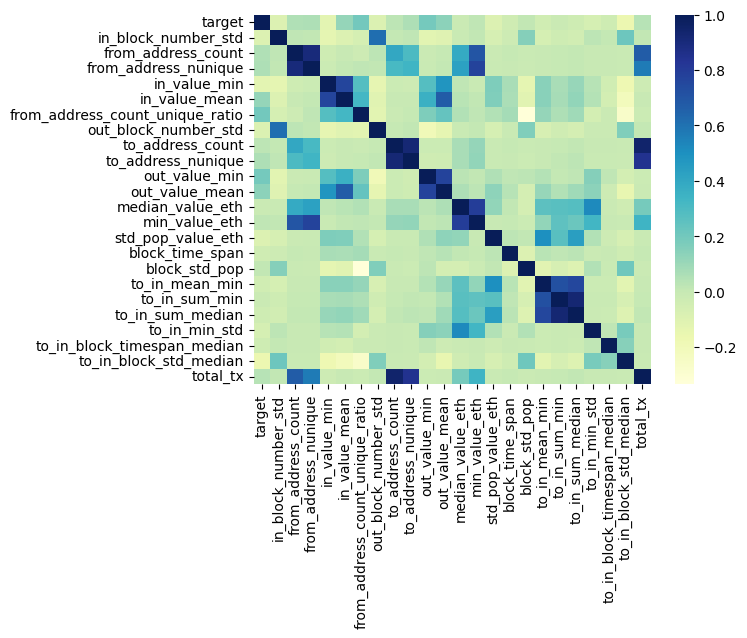

In [17]:
import seaborn as sns
sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=False)


%%time

clf = EasyEnsembleClassifier(n_estimators= 200, #800, 
                             sampling_strategy=0.1, 
                             base_estimator=lgb.LGBMClassifier(boosting_type='goss', max_depth=20, random_state=0, n_estimators=200, learning_rate=0.09, num_leaves=500), 
                             random_state=RANDOM_SEED, 
                             n_jobs=cpu_count(),verbose=0).fit(X_train, y_train)

In [18]:
%%time
# Generate Submission For Test set

test_data = generate_features(test_dfs, test_ids, from_out_test, to_in_test)
X_test, y_test = get_feature_and_labels(test_data, no_labels=True)

CPU times: user 1min 21s, sys: 22.1 s, total: 1min 43s
Wall time: 2min 33s


In [19]:
%%time
target_names = ['normal', 'phishing-scam']

from sklearn.model_selection import StratifiedKFold
FOLDS= 3

kf = StratifiedKFold(n_splits=FOLDS,shuffle=True,random_state=42)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    clf = EasyEnsembleClassifier(n_estimators= 200, #800, 
                             sampling_strategy=0.5, 
                             base_estimator=lgb.LGBMClassifier(boosting_type='goss', max_depth=20, random_state=0, n_estimators=200, learning_rate=0.09, num_leaves=500), 
                             random_state=RANDOM_SEED, 
                             n_jobs=cpu_count(),verbose=1).fit(xtr, ytr)
    y_val_preds= np.array([class_proba[1] for class_proba in clf.predict_proba(xvl)])
    score = average_precision_score(yvl,y_val_preds)   
    print(f"Average Precision Score: {average_precision_score(yvl, y_val_preds)}")
    print(classification_report(yvl, y_val_preds >= 0.5, target_names=target_names))
    cv_score.append(score)    
    pred_test = np.array([class_proba[1] for class_proba in clf.predict_proba(X_test)])
    pred_test_full +=pred_test
    i+=1

1 of KFold 5


/usr/local/lib/python3.8/dist-packages/imblearn/ensemble/_easy_ensemble.py:277: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   34.1s remaining:  6.2min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:   38.1s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    1.7s remaining:   18.5s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.9s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


Average Precision Score: 0.9354664666802753
               precision    recall  f1-score   support

       normal       0.96      0.97      0.96      2000
phishing-scam       0.87      0.85      0.86       538

     accuracy                           0.94      2538
    macro avg       0.92      0.91      0.91      2538
 weighted avg       0.94      0.94      0.94      2538



[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   55.2s remaining: 10.1min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  1.0min finished


2 of KFold 5


/usr/local/lib/python3.8/dist-packages/imblearn/ensemble/_easy_ensemble.py:277: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   27.5s remaining:  5.0min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:   30.6s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    1.6s remaining:   17.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.9s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


Average Precision Score: 0.9339385035690029
               precision    recall  f1-score   support

       normal       0.96      0.95      0.96      2000
phishing-scam       0.84      0.86      0.85       538

     accuracy                           0.93      2538
    macro avg       0.90      0.91      0.90      2538
 weighted avg       0.94      0.93      0.94      2538



[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   55.1s remaining: 10.1min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  1.0min finished


3 of KFold 5


/usr/local/lib/python3.8/dist-packages/imblearn/ensemble/_easy_ensemble.py:277: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   27.6s remaining:  5.1min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:   30.4s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    1.6s remaining:   17.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.8s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


Average Precision Score: 0.9267384488220509
               precision    recall  f1-score   support

       normal       0.96      0.96      0.96      2000
phishing-scam       0.84      0.84      0.84       538

     accuracy                           0.93      2538
    macro avg       0.90      0.90      0.90      2538
 weighted avg       0.93      0.93      0.93      2538



[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   55.2s remaining: 10.1min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  1.0min finished
/usr/local/lib/python3.8/dist-packages/imblearn/ensemble/_easy_ensemble.py:277: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


4 of KFold 5


[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   27.5s remaining:  5.0min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:   30.7s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    1.7s remaining:   18.2s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.9s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


Average Precision Score: 0.9328847593350644
               precision    recall  f1-score   support

       normal       0.96      0.96      0.96      2000
phishing-scam       0.86      0.86      0.86       538

     accuracy                           0.94      2538
    macro avg       0.91      0.91      0.91      2538
 weighted avg       0.94      0.94      0.94      2538



[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   55.1s remaining: 10.1min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  1.0min finished
/usr/local/lib/python3.8/dist-packages/imblearn/ensemble/_easy_ensemble.py:277: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


5 of KFold 5


[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   27.2s remaining:  5.0min
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:   30.1s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    1.6s remaining:   17.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.9s finished
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


Average Precision Score: 0.9388077675297408
               precision    recall  f1-score   support

       normal       0.96      0.96      0.96      2000
phishing-scam       0.86      0.86      0.86       538

     accuracy                           0.94      2538
    macro avg       0.91      0.91      0.91      2538
 weighted avg       0.94      0.94      0.94      2538



[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:   54.7s remaining: 10.0min


CPU times: user 8min 47s, sys: 29.2 s, total: 9min 17s
Wall time: 8min 21s


[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  1.0min finished


In [20]:
from joblib import dump, load

dump(clf, 'sept-18-2022-easy-ensemble-2_lgbm.joblib') 

['sept-18-2022-easy-ensemble-2_lgbm.joblib']

In [21]:
print(pred_test_full/3)

[0.00890747 0.00031162 0.03677183 ... 0.00059752 0.00073068 0.00091835]


In [22]:
%%time
submission = test_data[['Id']].copy()
submission['Predicted'] = pred_test_full/FOLDS

CPU times: user 5.65 ms, sys: 144 µs, total: 5.79 ms
Wall time: 4.35 ms


In [24]:
submission.to_csv(f'benchmark_submission_lgbm_latef{FOLDS}.csv', index=None)

In [ ]:
%%timeit
# Calculate prediction latency

clf.predict_proba(X_test.sample(1))

## Areas of Improvement

1. Replace base estimator Xgboost with [lightGBM](https://github.com/microsoft/LightGBM) to reduce prediction latency (See [Which algorithm takes the crown: Light GBM vs XGBOOST?](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)).
2. As mentioned in the data cleaning section of “Phishing Scam Detection on Ethereum: Towards Financial Security for Blockchain Ecosystem.”, remove Smart Contract transactions from training data. 

> 4.2 Data Cleaning - First of all, smart contracts often have complex logic and are not convenient for phishing scams. Furthermore, smart contracts account for very little in the phishing addresses (i.e., 2.6%), and they usually relate to tokens.